<a href="https://colab.research.google.com/github/EnocPinto/Time-series-analysis-with-Python/blob/main/Univariate_Analysis_DFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Remove all variables
%reset

In [ ]:
#If error importing auto_arima, run this code first
!pip install pmdarima

In [ ]:
#Libraries 

#General libraries
import pandas as pd 
import numpy as np 
from datetime import datetime
from math import sqrt

#Plotting libraries
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

#Statistical libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

# **Table of content**

1. Exploratory data analysis
2. Model selection ARIMA
  - 2.1 Train test split and ACF/PACF
  - 2.2 Auto_arima for model selection
3. Model fit ARIMA
4. Model forecast and performance assessment ARIMA
  - 4.1 Forecast on train data
  - 4.2 Forecast on test data
5. Data preparation for LSTM and plotting
6. LSTM Univariate models
  - 6.1 Model assessment function and early's stops callbacks
  - 6.2 Model_1
  - 6.3 Model_2
  - 6.4 Model_3
  - 6.5 Visualizing results
7. Predictions on validation data, last 12 months - One-step ahead
8. Predictions on validation data, last 12 months - Multi-step ahead

#**1. Exploratory data analysis**

In [ ]:
#Read The Federal Funds Effective Rate dataset (DFF)
DFF = pd.read_csv("DFF.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
DFF

,DFF
DATE,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88
...,...
2022-06-26,1.58
2022-06-27,1.58
2022-06-28,1.58


In [ ]:
#Check if there are missing values and how missing they are coded in the dataset
print(DFF[pd.to_numeric(DFF["DFF"], errors="coerce").isnull()])

Empty DataFrame
Columns: [DFF]
Index: []


In [ ]:
#Reshape the variable and calculate the DFT monthly average value
DFF_monthly = DFF.resample("M").apply(np.mean)
DFF_monthly

,DFF
DATE,
1954-07-31,0.799355
1954-08-31,1.220645
1954-09-30,1.066667
1954-10-31,0.848710
1954-11-30,0.833667
...,...
2022-02-28,0.080000
2022-03-31,0.200968
2022-04-30,0.330000


In [ ]:
#Summary statistics
DFF_monthly.describe().applymap('{:,.2f}'.format)

,DFF
count,816.00
mean,4.61
std,3.63
min,0.05
25%,1.75
50%,4.14
75%,6.32
max,19.10


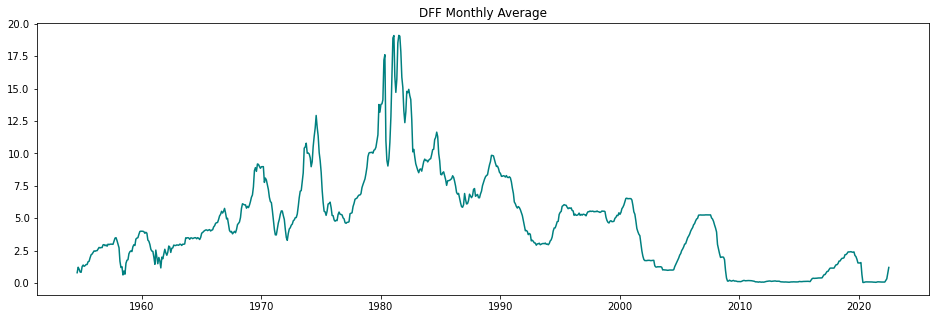

In [ ]:
#Plot DFF time series
plt.figure(figsize=(16,5))
plt.title("DFF Monthly Average")
plt.plot(DFF_monthly, color="teal")

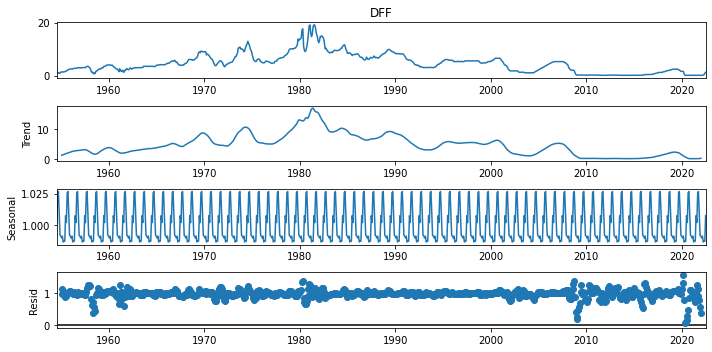

In [ ]:
#Decompose Time Series Data into Trend and Seasonality (Multiplicative)
decomposition = seasonal_decompose(DFF_monthly["DFF"], 
                                   model="multiplicative").plot()

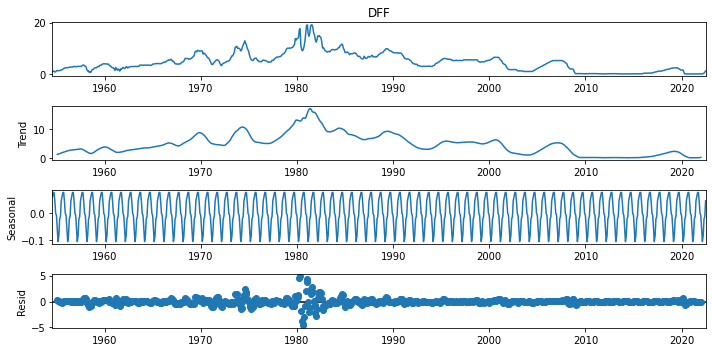

In [ ]:
#Decompose Time Series Data into Trend and Seasonality (Additive)
decomposition = seasonal_decompose(DFF_monthly["DFF"], 
                                   model="additive").plot()

In [ ]:
#Check if the data is stationary using the Augmented Dickey–Fuller test
Stationary_test = adfuller(DFF_monthly["DFF"])
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("Time series is not stationary")
else:
    print("Time series is stationary")

Test statistic: -2.7472611965128366
p-value: 0.06621093940489298
Time series is not stationary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0, 0.5, 'Autocorrelation')

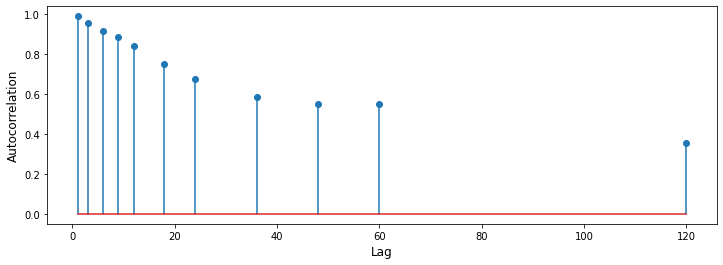

In [ ]:
#Find the optimal differenciate order 
#This method computes the Pearson correlation between the Series and its shifted self.
lags = [1, 3, 6, 9, 12, 18, 24, 36, 48, 60, 120] 
autocorrs = [DFF_monthly.DFF.autocorr(lag=lag) for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

In [ ]:
#Compute first difference order
DFF_monthly["DFF_diff"] = DFF_monthly.DFF.diff(1) 
DFF_monthly

,DFF,DFF_diff
DATE,,
1954-07-31,0.799355,NaN
1954-08-31,1.220645,0.421290
1954-09-30,1.066667,-0.153978
1954-10-31,0.848710,-0.217957
1954-11-30,0.833667,-0.015043
...,...,...
2022-02-28,0.080000,0.000645
2022-03-31,0.200968,0.120968
2022-04-30,0.330000,0.129032


In [ ]:
#Check if the data is stationary using the Augmented Dickey–Fuller test
result = adfuller(DFF_monthly["DFF_diff"][1:]) #Exclud 1st values as the series cant contain NaN values
print(f"Test statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Time series is not stationary")
else:
    print("Time series is stationary")

Test statistic: -6.324669526102394
p-value: 3.0067641891280694e-08
Time series is stationary


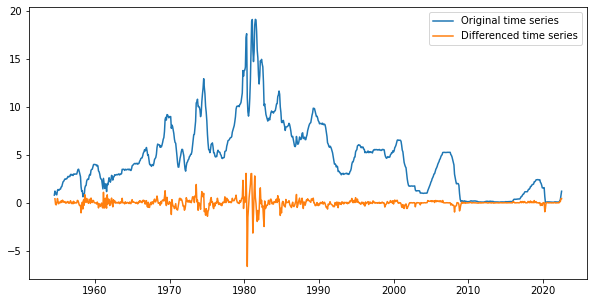

In [ ]:
#Plot original and differenced series 
plt.plot(DFF_monthly.DFF, label="Original time series")
plt.plot(DFF_monthly.DFF_diff, label="Differenced time series")
plt.legend()

# **2. Model selection**

## **2.1 Train test split and ACF/PACF**

In [ ]:
#Split train and test(12 months)
train = DFF_monthly.iloc[:-12]
test = DFF_monthly.iloc[-12:]
print(train.shape, test.shape)

(804, 2) (12, 2)


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


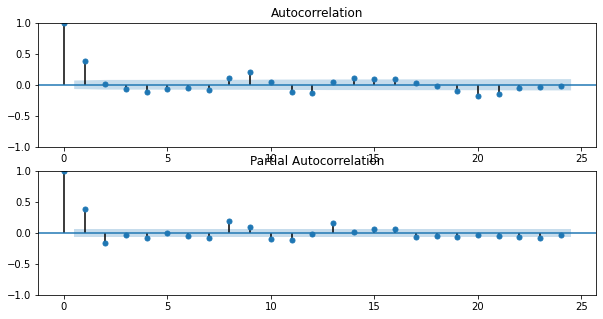

In [ ]:
#Plot ACF and PACF
fig, ax = plt.subplots(2)
plot_acf(train["DFF_diff"][1:], lags=24, ax=ax[0])      #Excluding first two values as they are NaN
plot_pacf(train["DFF_diff"][1:], lags=24, ax=ax[1]);

## **2.2 Auto_arima for model selection**

In [ ]:
#ARIMA stepwise model selection using AIC (Akaike information criterion)
model_selection = auto_arima(train["DFF"], trace = True, supress_warnings = True,  information_criterion = "aic", seasonal=False, approximation=False, stepwise=False)
model_selection.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1148.460, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1007.226, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1007.829, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1009.802, Time=1.00 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1006.079, Time=1.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1003.790, Time=1.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1023.813, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1007.927, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1006.425, Time=1.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1008.279, Time=1.72 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1005.947, Time=3.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1005.883, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1005.169, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1006.004, Time=1.65 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=991.593, Time=2.53 sec
 ARIMA(3,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  804
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -488.797
Date:                Wed, 12 Oct 2022   AIC                            991.593
Time:                        16:39:45   BIC                           1024.412
Sample:                    07-31-1954   HQIC                          1004.198
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.017     -0.024      0.981      -0.034       0.033
ar.L1          1.2614      0.030     41.621      0.000       1.202       1.321
ar.L2         -0.9194      0.027    -34.046      0.000      -0.972      -0.866
ma.L1         -0.8237      0.036    -23.199      0.000      -0.893      -0.754
ma.L2          0.4508      0.025     18.092      0.000       0.402       0.500
ma.L3          0.3297      0.026     12.884      0.000       0.280       0.380
sigma2         0.1977      0.003     63.208      0.000       0.192       0.204
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):            138491.95
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -3.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#ARIMA stepwise model selection using AIC (Akaike information criterion)
model_selection = auto_arima(train["DFF"], trace = True, supress_warnings = True,  information_criterion = "bic", seasonal=False, approximation=False, stepwise=False)
model_selection.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1157.837, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1021.291, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1026.582, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=1033.244, Time=0.45 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : BIC=1034.209, Time=0.53 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : BIC=1036.609, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1037.878, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1026.680, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1029.867, Time=1.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=1036.410, Time=1.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : BIC=1038.765, Time=1.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=1024.636, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=1028.610, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=1034.134, Time=1.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : BIC=1024.412, Time=4.21 sec
 ARIMA(3,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  804
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -500.613
Date:                Wed, 12 Oct 2022   AIC                           1007.226
Time:                        16:40:23   BIC                           1021.291
Sample:                    07-31-1954   HQIC                          1012.628
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.025     -0.026      0.979      -0.049       0.048
ma.L1          0.4249      0.016     26.113      0.000       0.393       0.457
sigma2         0.2037      0.003     71.840      0.000       0.198       0.209
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):             98234.77
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -2.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# **3. Model fit ARIMA(2,1,3)**

In [ ]:
#Model fit
model = ARIMA(train["DFF"], order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                    DFF   No. Observations:                  804
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -488.797
Date:                Wed, 12 Oct 2022   AIC                            989.594
Time:                        16:40:26   BIC                           1017.724
Sample:                    07-31-1954   HQIC                          1000.398
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2614      0.030     41.693      0.000       1.202       1.321
ar.L2         -0.9194      0.027    -34.099      0.000      -0.972      -0.867
ma.L1         -0.8237      0.035    -23.239      0.0

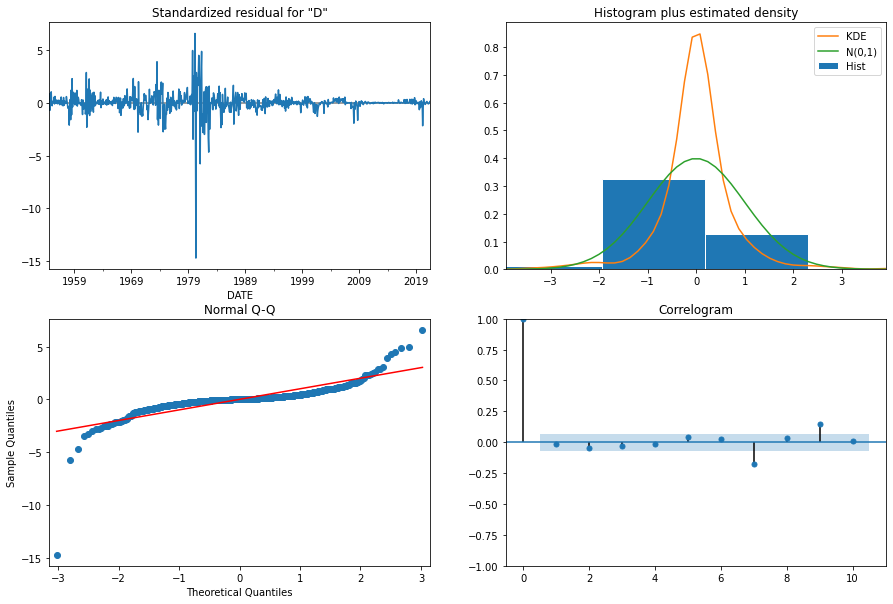

In [ ]:
#Model diagnostics plots
residuals = model_fit.resid
MAE = np.mean(np.abs(residuals))
model_fit.plot_diagnostics(figsize=[15,10])
plt.show()

# **4. Model forecast and performance assessment** 

In [ ]:
#Define a function to assess model performance

def model_evualuation_metrics (trainY, trainPredict):

  ### Mean Absolute Error (MAE)  
  train_MAE = metrics.mean_absolute_error(trainY, trainPredict)
  print("Model MAE: %.2f" % (train_MAE))
  ### Mean Squared Error (MSE)
  train_MSE = metrics.mean_squared_error(trainY, trainPredict)
  print("Model MSE: %.2f" % (train_MSE))
  ### Root Mean Squared Error(RMSE)
  train_RMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
  print("Model RMSE: %.2f" % (train_RMSE))
  ### R-Squared 
  train_R2 = metrics.r2_score(trainY, trainPredict)
  print("Model R2: %.2f" % (train_R2))

## **4.1 Forecast on train data**

In [ ]:
#Forecast on the training data
prediction_train_start = 0
prediction_train_end = len(train)-1
forecast = model_fit.predict(prediction_train_start, prediction_train_end)

In [ ]:
#Add the predicted values to the train data 
train["Forecast"] = forecast
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DFF,DFF_diff,Forecast
DATE,,,
1954-07-31,0.799355,NaN,0.000000
1954-08-31,1.220645,0.421290,0.799355
1954-09-30,1.066667,-0.153978,1.391522
1954-10-31,0.848710,-0.217957,0.950683
1954-11-30,0.833667,-0.015043,0.765435
...,...,...,...
2021-02-28,0.075714,-0.009447,0.102204
2021-03-31,0.069677,-0.006037,0.116357
2021-04-30,0.069000,-0.000677,0.102484


In [ ]:
#Model evaluation metrics on training data
model_evualuation_metrics(train["DFF"], train["Forecast"])

Model MAE: 0.22
Model MSE: 0.20
Model RMSE: 0.45
Model R2: 0.98


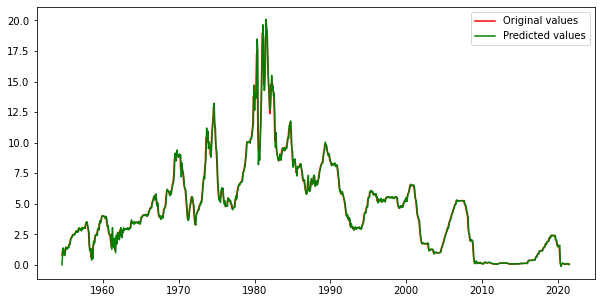

In [ ]:
#Plot results
plt.plot(train["DFF"], color = "red", label= "Original values")
plt.plot(train["Forecast"], color = "green", label = "Predicted values")
plt.legend(loc="best")
plt.show()

## **4.2 Forecast on test data**

In [ ]:
#Forecast on testing data
prediction_test_start = len(train)
prediction_test_end = len(DFF_monthly)-1
forecast = model_fit.get_prediction(prediction_test_start, prediction_test_end) #Using get_predictions as it also preuduce 95% CI

In [ ]:
#Get confidence intervals for forecast on testing data
forecast_conf_int = forecast.conf_int(alpha=0.05) # 95% confidence intervals
lower_series = pd.Series(forecast_conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(forecast_conf_int.iloc[:, 1], index=test.index)

In [ ]:
#Get predicted value
forecast_values = forecast.predicted_mean

In [ ]:
#Model evaluation metrics on training data
model_evualuation_metrics(test["DFF"], forecast_values)

Model MAE: 0.21
Model MSE: 0.16
Model RMSE: 0.40
Model R2: -0.36


In [ ]:
#Print orignal test values and predicted values
test_complete = pd.concat([test, forecast_values], axis=1)
test_complete.rename(columns={"DFF": "Original values", "predicted_mean": "Predicted values"}, inplace=True)
test_complete.drop(["DFF_diff"], axis=1, inplace=True)
test_complete

,Original values,Predicted values
2021-07-31,0.098065,0.052840
2021-08-31,0.092258,0.022024
2021-09-30,0.079333,0.023599
2021-10-31,0.079032,0.053918
2021-11-30,0.079667,0.090714
2021-12-31,0.079677,0.109253
2022-01-31,0.079355,0.098808
2022-02-28,0.080000,0.068589
2022-03-31,0.200968,0.040074
2022-04-30,0.330000,0.031888


In [ ]:
#Print evaluation metrics for validation data
model_evualuation_metrics(test_complete["Original values"], test_complete["Predicted values"])

Model MAE: 0.21
Model MSE: 0.16
Model RMSE: 0.40
Model R2: -0.36


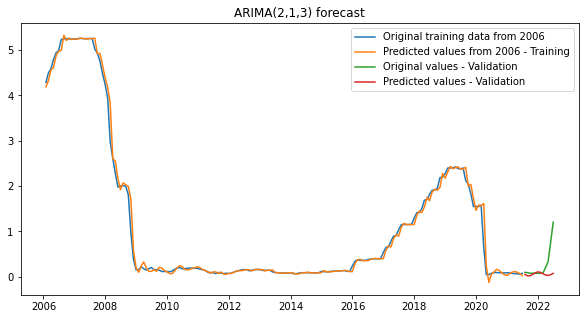

In [ ]:
#Plot original test values and predicted values 
plt.plot(train["DFF"][618:], label="Original training data from 2006")
plt.plot(train["Forecast"][618:], label="Predicted values from 2006 - Training")
plt.plot(test["DFF"], label="Original values - Validation")
plt.plot(forecast_values, label="Predicted values - Validation")
#plt.fill_between(forecast_conf_int.index, lower_series, upper_series, color="k", alpha=.15)
plt.title("ARIMA(2,1,3) forecast")
plt.legend()
plt.show()

# **5. Data preparation for LSTM and plotting**

In [ ]:
#Load data (Federal Funds Effective Rate (DFF)) and calculate monthly average
DFF = pd.read_csv("DFF.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=",")
DFF_monthly = DFF.resample("M").apply(np.mean)
DFF_monthly

,DFF
DATE,
1954-07-31,0.799355
1954-08-31,1.220645
1954-09-30,1.066667
1954-10-31,0.848710
1954-11-30,0.833667
...,...
2022-02-28,0.080000
2022-03-31,0.200968
2022-04-30,0.330000


In [ ]:
#Create training, test and validation partitions for plotting
#Validation set 
DFF_monthly_validation = DFF_monthly.iloc[-12:]

#Remove the 12 observations for validation and split remaining into train and test (70% - 30%)
DFF_monthly = DFF_monthly[:-12]

#Create train and test data sets
train_size = int(len(DFF_monthly) * 0.7)
test_size = len(DFF_monthly) - train_size
DFF_monthly_train, DFF_monthly_test = DFF_monthly[0:train_size], DFF_monthly[train_size:len(DFF_monthly)]

#Print the shape of train test and validation sets
print("DFF_monthly_train shape is {}".format(DFF_monthly_train.shape))
print("DFF_monthly_test shape is {}".format(DFF_monthly_test.shape))
print("DFF_monthly_validation shape is {}".format(DFF_monthly_validation.shape))

DFF_monthly_train shape is (562, 1)
DFF_monthly_test shape is (242, 1)
DFF_monthly_validation shape is (12, 1)


In [ ]:
#Save date for plotting, ignore the first 12 as they are burn predicting the first value
index = len(DFF_monthly_train)+len(DFF_monthly_test)
train_dates = pd.to_datetime(DFF_monthly.index[12:index])

#Convert the dataframe to a numpy array
DFF_monthly_val = DFF_monthly.values

In [ ]:
#Apply MinMaxScaler to escale the data between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1))
DFF_monthly_val = scaler.fit_transform(DFF_monthly_val) #Need a 2d array to apply scaler

#Confirm MinMaxScaler worked as intended 
print("DFF_monthly_val min value is {}".format(DFF_monthly_val.min()))
print("DFF_monthly_val max value is  {}".format(DFF_monthly_val.max()))

#Print shape
DFF_monthly_val.shape

DFF_monthly_val min value is 0.0
DFF_monthly_val max value is  1.0


(804, 1)

In [ ]:
#Variables for the model
sliding_window = 12  #Each prediction will be based on the prior 12 months 
n_output = 1   #Number of forecast values

In [ ]:
#Function to prepare data for LSTM model

def TS_LST_Univariate (dataset, sliding_window):
  """  Transofrm a sequence into a shape required by the model X 
  input = (Observations, sliding_window, mumber of features)
  output = (Observations, forecast values) """
  
  X = [] 
  Y = []

  for i in range(len(dataset)-sliding_window):
    X.append(dataset[i:i + sliding_window])
    Y.append(dataset[i + sliding_window])

  return np.array(X), np.array(Y)

In [ ]:
#Create X and Y train data sets
trainX, trainY = TS_LST_Univariate(DFF_monthly_val, sliding_window)

#Print the shape of trainX and trainY
print("trainX shape is {}".format(trainX.shape))
print("trainY shape is {}".format(trainY.shape))

trainX shape is (792, 12, 1)
trainY shape is (792, 1)


# **6. LSTM Univariate models**

In [ ]:
#Setting the random generator seed to ensure similar responses when re-running code
tf.random.set_seed(123)

## **6.1 Model assessment function and early's stops callbacks**

In [ ]:
def model_evualuation_metrics (trainY, trainPredict):

  ### Mean Absolute Error (MAE)  
  train_MAE = metrics.mean_absolute_error(trainY, trainPredict)
  print("Model MAE: %.2f" % (train_MAE))
  ### Mean Squared Error (MSE)
  train_MSE = metrics.mean_squared_error(trainY, trainPredict)
  print("Model MSE: %.2f" % (train_MSE))
  ### Root Mean Squared Error(RMSE)
  train_RMSE = np.sqrt(mean_squared_error(trainY, trainPredict))
  print("Model RMSE: %.2f" % (train_RMSE))
  ### R-Squared 
  train_R2 = metrics.r2_score(trainY, trainPredict)
  print("Model R2: %.2f" % (train_R2))

In [ ]:
#Early stop callback, stop training when when the validation loss stops improving 
early_stop_CB = EarlyStopping(monitor= "val_loss",       
                              min_delta=0.0005,           #Change of the monitor value less than min_delta, will count as no improvement
                              patience=20,                #Number of with no improvement after which the model will be stopped
                              mode="min")                 #Training will stop when the quantity monitored has stopped decreasing

In [ ]:
#Reduce the learning rate when the validation loss stopped improving.
decrease_learning_rate_CB = ReduceLROnPlateau(monitor = "val_loss",                              
                                              factor = 0.2,                       #Factor by which the learning rate will be reduced
                                              mode = "min", 
                                              patience = 20, 
                                              min_lr = 0.001)

## **6.2 Model_1**

In [ ]:
#Model_1 components
model_1 =Sequential()
model_1.add(LSTM(50, activation="relu"))
model_1.add(Dense(1))
model_1.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [ ]:
#Fit the model
history_1 = model_1.fit(trainX, 
                        trainY, 
                        validation_split=0.3, 
                        epochs=100, 
                        batch_size=64, 
                        verbose=1, 
                        callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
9/9 [==============================] - 2s 56ms/step - loss: 0.1162 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0745 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0347 - accuracy: 0.0000e+00 - val_loss: 0.0104 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0069 - accuracy: 0.0018 - val_loss: 0.0062 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0061 - accuracy: 0.0018 - val_loss: 0.0093 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - 

In [ ]:
#Print model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


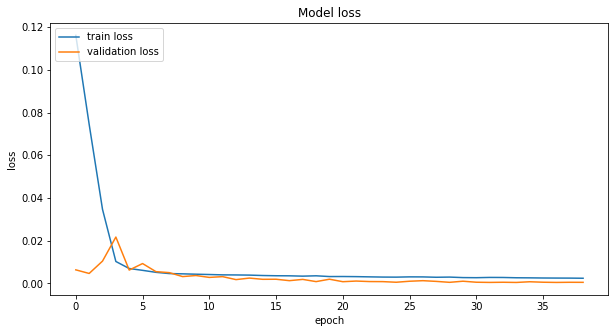

In [ ]:
#Plot the evolution of the training and validation loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
#Calculate the original values for trainY
trainY_Original = scaler.inverse_transform(trainY)

#Make predictions
trainPredict_1 = model_1.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_1 = scaler.inverse_transform(trainPredict_1)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_1)

Model MAE: 0.48
Model MSE: 0.64
Model RMSE: 0.80
Model R2: 0.95


## **6.3 Model_2**

In [ ]:
#Model_2 components
model_2 =Sequential()
model_2.add(LSTM(50, activation="relu", return_sequences=True))
model_2.add(LSTM(50, activation="relu"))
model_2.add(Dense(1))
model_2.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [ ]:
#Fit the model_2 applying same call bancks
history_2 = model_2.fit(trainX, 
                      trainY, 
                      validation_split=0.3, 
                      epochs=100, 
                      batch_size=64, 
                      verbose=1, 
                      callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
9/9 [==============================] - 5s 83ms/step - loss: 0.1118 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0612 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0175 - accuracy: 0.0000e+00 - val_loss: 0.0524 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0142 - accuracy: 0.0018 - val_loss: 0.0179 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0115 - accuracy: 0.0018 - val_loss: 0.0168 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0080 - accuracy: 0.0018 - val_loss: 0.0145 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 23ms/step - loss

In [ ]:
#Print model summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 50)            10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


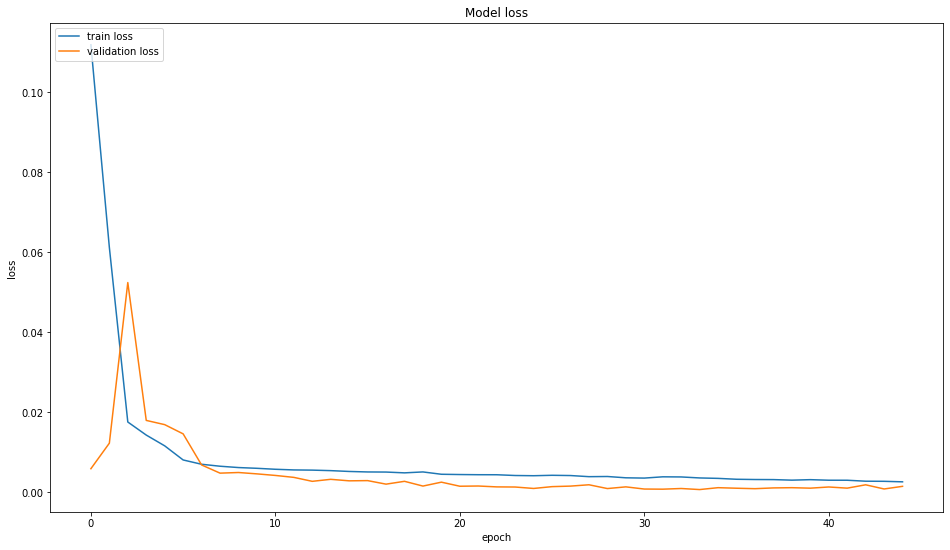

In [ ]:
#Plot the evolution of the training and validation loss
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
#Make predictions
trainPredict_2 = model_2.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_2 = scaler.inverse_transform(trainPredict_2)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_2)

Model MAE: 0.61
Model MSE: 0.79
Model RMSE: 0.89
Model R2: 0.94


## **6.4 Model_3**

In [ ]:
#Model_3 components
model_3 =Sequential()
model_3.add(LSTM(50, activation="relu", return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(50, activation="relu"))
model_3.add(Dense(1))
model_3.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

In [ ]:
#Fit the model_3 applying same call bancks
history_3 = model_3.fit(trainX, 
                      trainY, 
                      validation_split=0.3, 
                      epochs=100, 
                      batch_size=60, 
                      verbose=1, 
                      callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
10/10 [==============================] - 5s 99ms/step - loss: 0.1129 - accuracy: 0.0000e+00 - val_loss: 0.0047 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0425 - accuracy: 0.0000e+00 - val_loss: 0.0131 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0122 - accuracy: 0.0018 - val_loss: 0.0302 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0093 - accuracy: 0.0018 - val_loss: 0.0143 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0093 - accuracy: 0.0018 - val_loss: 0.0154 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0077 - accuracy: 0.0018 - val_loss: 0.0147 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 0s 26ms/s

In [ ]:
#Print model summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 12, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


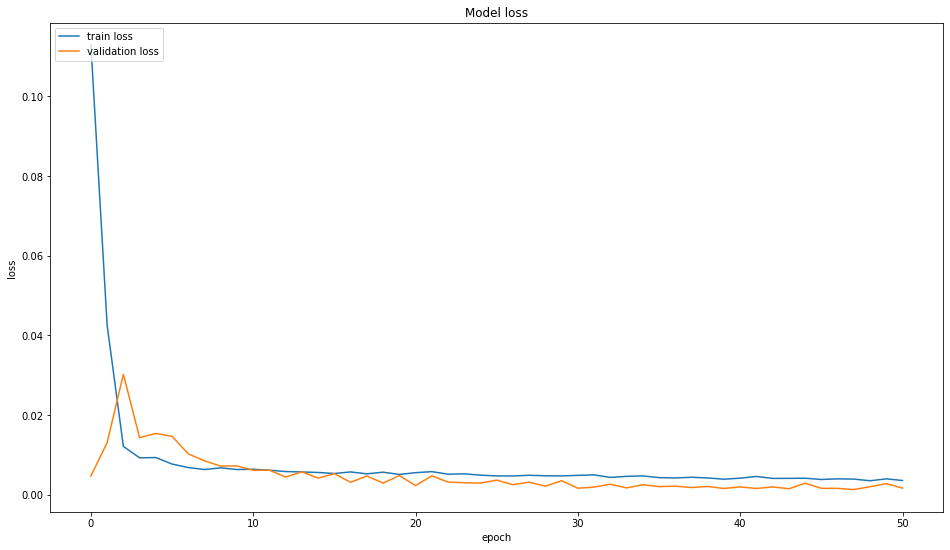

In [ ]:
#Plot the evolution of the training and validation loss
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
#Make predictions
trainPredict_3 = model_3.predict(trainX)

#Escale-back the values to compared them agains the original values
trainPredict_3 = scaler.inverse_transform(trainPredict_3)

#Print evaluation metrics
model_evualuation_metrics(trainY_Original, trainPredict_3)

Model MAE: 0.68
Model MSE: 1.03
Model RMSE: 1.02
Model R2: 0.92


## **6.5. Visualizing results**

In [ ]:
#Scale back original values 
#trainY = scaler.inverse_transform(trainY)

#Convert predictions into DataFrames
df_trainY = pd.DataFrame(trainY_Original, columns = ["DFF_Original"])
df_trainPredict_1 = pd.DataFrame(trainPredict_1, columns = ["DFF_pred_1"])
df_trainPredict_2 = pd.DataFrame(trainPredict_2, columns = ["DFF_pred_2"])
df_trainPredict_3 = pd.DataFrame(trainPredict_3, columns = ["DFF_pred_3"])

#Combine original and predicted values
Train_comp = pd.concat([df_trainY, df_trainPredict_1, df_trainPredict_2, df_trainPredict_3], axis=1)

#Add the dates to original and predicted values dataframe
Train_comp["Date"] = train_dates
Train_comp.set_index("Date", inplace=True)

Train_comp

,DFF_Original,DFF_pred_1,DFF_pred_2,DFF_pred_3
Date,,,,
1955-07-31,1.682258,1.518454,1.975284,1.753905
1955-08-31,1.956452,1.592653,2.044290,1.808376
1955-09-30,2.178667,1.720888,2.145085,1.886590
1955-10-31,2.240323,1.873618,2.266655,1.982245
1955-11-30,2.354333,2.007915,2.391295,2.080845
...,...,...,...,...
2021-02-28,0.075714,0.180670,0.820070,0.933949
2021-03-31,0.069677,0.196747,0.845528,0.930542
2021-04-30,0.069000,0.200627,0.854945,0.931026


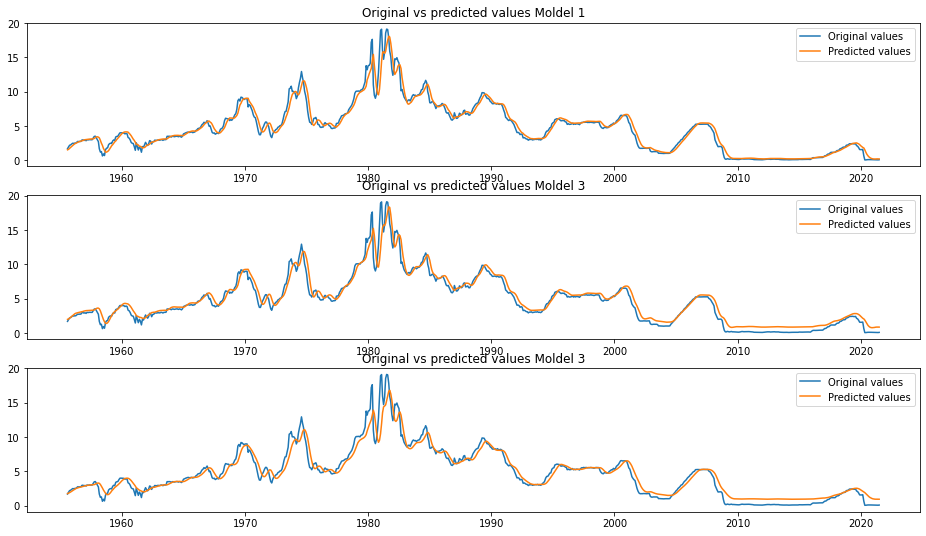

In [ ]:
#Plot in sample prediction for the three models 
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(Train_comp.DFF_Original, label= "Original values")
ax1.plot(Train_comp.DFF_pred_1, label = "Predicted values")
ax1.set_title("Original vs predicted values Moldel 1")
ax1.legend(loc="best")

ax2.plot(Train_comp.DFF_Original, label= "Original values")
ax2.plot(Train_comp.DFF_pred_2, label = "Predicted values")
ax2.set_title("Original vs predicted values Moldel 3")
ax2.legend(loc="best")

ax3.plot(Train_comp.DFF_Original, label= "Original values")
ax3.plot(Train_comp.DFF_pred_3, label = "Predicted values")
ax3.set_title("Original vs predicted values Moldel 3")
ax3.legend(loc="best")

# 7. Predictions on validation data, last 12 months - **One-step ahead**

In [ ]:
#Parameters
future = 12 #Months
prediction = []

initial_data = DFF_monthly_val[-sliding_window:] #Final 24 data points in train to predict firt value of validation set
initial_data = initial_data.reshape(1, sliding_window, 1) #Reshap

In [ ]:
for i in range(len(DFF_monthly_validation)):
    current_pred = model_1.predict(initial_data)[0]
    prediction.append(current_pred)
    initial_data = np.append(initial_data[:,1:,:],[[current_pred]],axis=1)

In [ ]:
#Escale-back the values to compared them agains the original values
prediction_new = scaler.inverse_transform(prediction)

In [ ]:
#Convine predicted and original validation values
df_trainY_val = prediction_new.ravel()
DFF_monthly_validation.insert(1, "DFF_Pred", df_trainY_val)

In [ ]:
#Print evaluation metrics for validation data
model_evualuation_metrics(DFF_monthly_validation["DFF"], DFF_monthly_validation["DFF_Pred"])

Model MAE: 0.25
Model MSE: 0.08
Model RMSE: 0.29
Model R2: 0.30


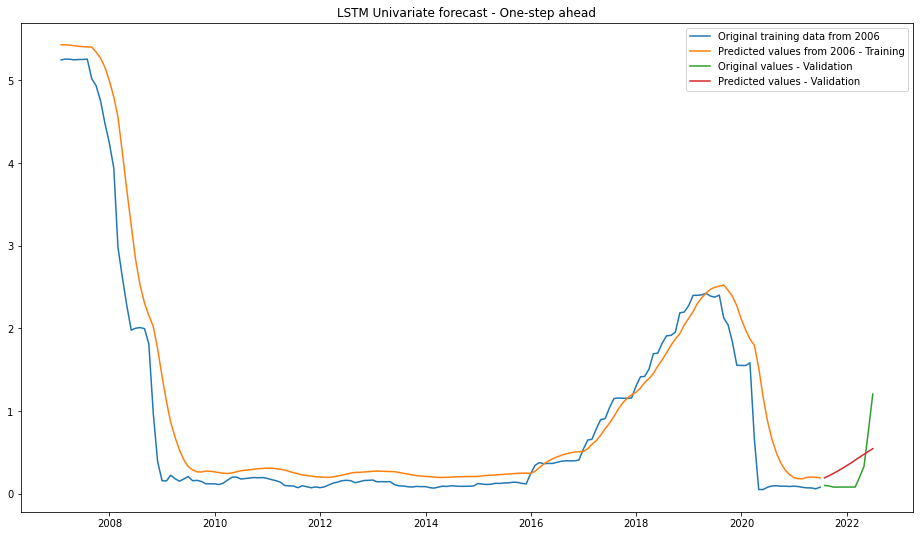

In [ ]:
#Plot validation values and original data from 1996
plt.plot(Train_comp.DFF_Original[618:], label= "Original training data from 2006")
plt.plot(Train_comp.DFF_pred_1[618:], label= "Predicted values from 2006 - Training")
plt.plot(DFF_monthly_validation.DFF, label= "Original values - Validation")
plt.plot(DFF_monthly_validation.DFF_Pred, label = "Predicted values - Validation")
plt.title("LSTM Univariate forecast - One-step ahead")
plt.legend(loc="best")
plt.show()

# 8. Predictions on validation data, last 12 months - **Multi-step ahead**

In [ ]:
#Sequence adjustment parameters
sliding_window = 12
forecast_values = 12
n_features = 1

In [ ]:
#Function to prepare data for LSTM model univariate Multi-step ahead

def TS_LST_Univariate_MultiStep (dataset, sliding_window, forecast_values):
  """  Transofrm a sequence into a shape required by the model X 
  input = (Observations, sliding_window, mumber of features)
  output = (Observations, forecast values) """
  
  X = [] 
  Y = []

  for i in range(sliding_window, len(dataset) - forecast_values +1):
    X.append(dataset[i:i + sliding_window])
    Y.append(dataset[i - 1: i + forecast_values -1, 0])

  return np.array(X), np.array(Y)

In [ ]:
#Create X and Y train data sets
trainX_MultiStep, trainY_MultiStep = TS_LST_Univariate_MultiStep(DFF_monthly_val, sliding_window, forecast_values)

#Print the shape of trainX and trainY
print("trainX shape is {}".format(trainX_MultiStep.shape))
print("trainY shape is {}".format(trainY_MultiStep.shape))

trainX shape is (781, 12, 1)
trainY shape is (781, 12)


In [ ]:
#Model_1 components (Adjust Dense Layer for 12 Multi-step ahead forecast)
model_1_MultiStep = Sequential()
model_1_MultiStep.add(LSTM(50, activation="relu"))
model_1_MultiStep.add(Dense(12))
model_1_MultiStep.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
#Fit the model
history_1_MultiStep = model_1_MultiStep.fit(trainX_MultiStep, 
                                            trainY_MultiStep, 
                                            validation_split=0.3, 
                                            epochs=100, 
                                            batch_size=60, 
                                            verbose=1, 
                                            callbacks=[early_stop_CB,decrease_learning_rate_CB])

Epoch 1/100
10/10 [==============================] - 2s 44ms/step - loss: 0.1295 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1032 - val_loss: 0.0068 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0773 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0451 - val_loss: 0.0165 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0247 - val_loss: 0.0171 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0122 - val_loss: 0.0145 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0071 - val_loss: 0.0122 - lr: 0.0010
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0110 - lr: 0.0010
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.0

In [ ]:
#Print model summary
model_1_MultiStep.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 12)                612       
                                                                 
Total params: 11,012
Trainable params: 11,012
Non-trainable params: 0
_________________________________________________________________


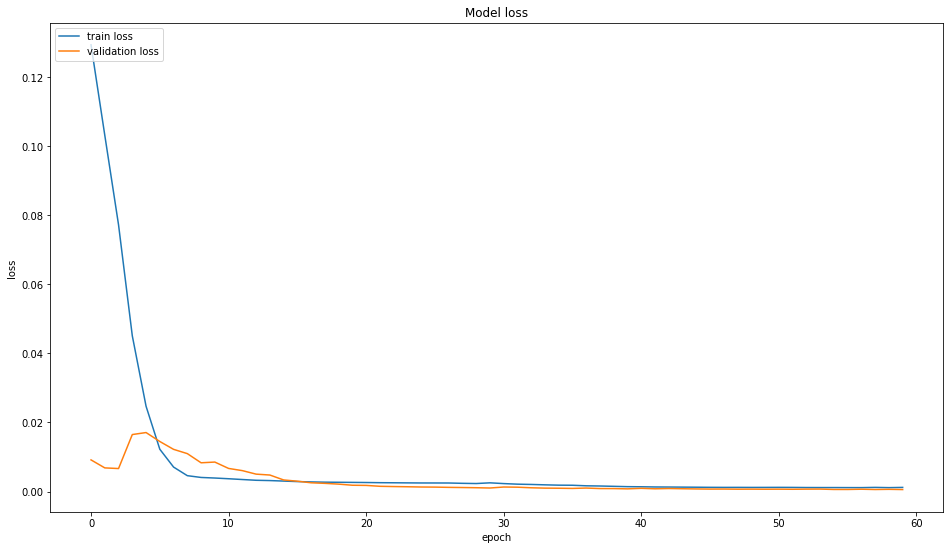

In [ ]:
#Plot the evolution of the training and validation loss
plt.plot(history_1_MultiStep.history["loss"])
plt.plot(history_1_MultiStep.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "validation loss"], loc="upper left")
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [ ]:
#Make predictions on trainig data
trainPredict_1_MultiStep = model_1_MultiStep.predict(trainX_MultiStep)

#Escale-back the values to compared them agains the original values
trainPredict_1_MultiStep = scaler.inverse_transform(trainPredict_1_MultiStep)
trainY_1 = trainY_MultiStep
trainY_1 = scaler.inverse_transform(trainY_1)

#Print evaluation metrics
model_evualuation_metrics(trainY_1, trainPredict_1_MultiStep)

Model MAE: 0.35
Model MSE: 0.34
Model RMSE: 0.59
Model R2: 0.97


In [ ]:
#Make predictions on validation data
trainPredict_1_MultiStep = model_1_MultiStep.predict(initial_data)

#Escale-back the values to compared them agains the original values
prediction_new_MultiStep = scaler.inverse_transform(trainPredict_1_MultiStep)

In [ ]:
#Convine predicted and original validation values
df_trainY_val_MultiStep = prediction_new_MultiStep.ravel()
DFF_monthly_validation.insert(2, "DFF_Pred_MUltiStep", df_trainY_val_MultiStep)
DFF_monthly_validation

,DFF,DFF_Pred,DFF_Pred_MUltiStep
DATE,,,
2021-07-31,0.098065,0.191542,0.370713
2021-08-31,0.092258,0.217072,0.786443
2021-09-30,0.079333,0.244386,0.850195
2021-10-31,0.079032,0.273897,0.622218
2021-11-30,0.079667,0.305247,0.872139
2021-12-31,0.079677,0.337990,0.544772
2022-01-31,0.079355,0.371857,0.479770
2022-02-28,0.080000,0.406397,0.562104
2022-03-31,0.200968,0.441182,1.174004


In [ ]:
#Print evaluation metrics for validation data
model_evualuation_metrics(DFF_monthly_validation["DFF"], DFF_monthly_validation["DFF_Pred_MUltiStep"])

Model MAE: 0.51
Model MSE: 0.32
Model RMSE: 0.56
Model R2: -1.72


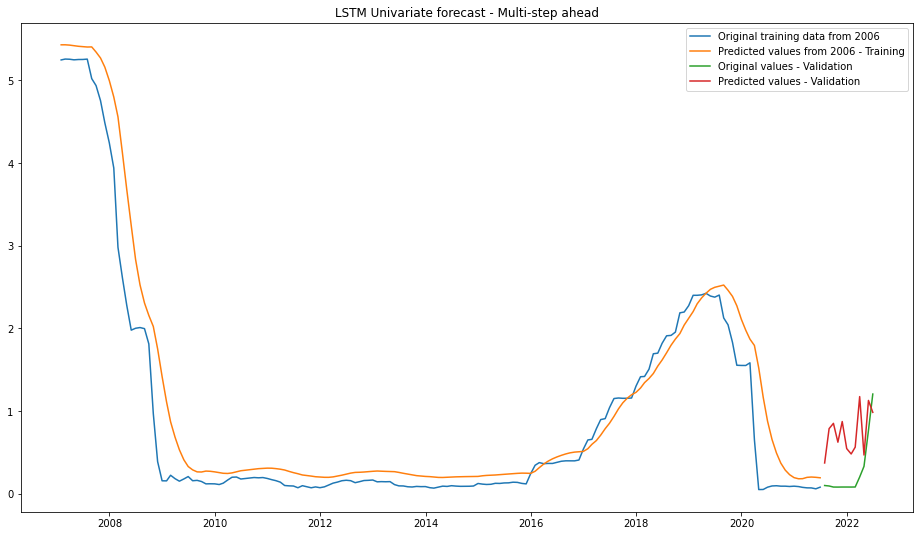

In [ ]:
#Plot validation values and original data from 1996
plt.plot(Train_comp.DFF_Original[618:], label= "Original training data from 2006")
plt.plot(Train_comp.DFF_pred_1[618:], label= "Predicted values from 2006 - Training")
plt.plot(DFF_monthly_validation.DFF, label= "Original values - Validation")
plt.plot(DFF_monthly_validation.DFF_Pred_MUltiStep, label = "Predicted values - Validation")
plt.title("LSTM Univariate forecast - Multi-step ahead")
plt.legend(loc="best")
plt.show()